# NYC

In [220]:
import pandas as pd   
import numpy as np 
import requests_cache
from retry_requests import retry
import openmeteo_requests as om
from datetime import datetime, timedelta
import requests
from io import StringIO
from meteostat import Point, Daily

In [221]:
current_date = datetime.now()
start_date = current_date - timedelta(days=120)

current_date_str = current_date.strftime('%Y-%m-%d')
start_date_str = start_date.strftime('%Y-%m-%d')

print("Start date:", start_date_str)
print("Current date:", current_date_str)

Start date: 2023-12-04
Current date: 2024-04-02


### OPEN METEO

In [76]:
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = om.Client(session = retry_session)
def get_data_openm(start_date,end_date):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 40.7143,
        "longitude": -74.006,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "wind_gusts_10m_max"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/New_York",
        "start_date": start_date,
		"end_date": end_date
    }
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
    daily_wind_gusts_10m_max = daily.Variables(6).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["rain_sum"] = daily_rain_sum
    daily_data["snowfall_sum"] = daily_snowfall_sum
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
    return daily_data


In [168]:
df1 = pd.DataFrame(data = get_data_openm(start_date_str, current_date_str))
df1['date'] = pd.to_datetime(df1['date']).dt.date
df1=df1.rename(columns={"temperature_2m_max": "max_temp", "temperature_2m_min": "min_temp", "precipitation_sum": "precipitation", "rain_sum": "rain", "snowfall_sum": "snowfall", "wind_speed_10m_max": "wind_speed", "wind_gusts_10m_max": "wind_gusts"})
df1=df1.fillna(0)
df1.head()

,date,max_temp,min_temp,precipitation,rain,snowfall,wind_speed,wind_gusts
0,2023-12-04,50.913498,41.193501,0.000000,0.000000,0.0,14.323789,22.817400
1,2023-12-05,42.993500,36.243500,0.000000,0.000000,0.0,7.908989,24.607000
2,2023-12-06,40.743500,32.373501,0.000000,0.000000,0.0,14.518113,26.172899
3,2023-12-07,37.773499,28.953501,0.003937,0.005906,0.0,11.504793,21.698900
4,2023-12-08,49.923500,32.373501,0.000000,0.000000,0.0,8.081114,15.882700


### VISUAL CROSSING

In [78]:
def get_data_vc(API_URL):
    response = requests.get(API_URL)
    if response.status_code == 200:
        csv_data = StringIO(response.text)
        df= pd.read_csv(csv_data)
        df=df[['datetime','tempmax','tempmin','precip','windspeed','windgust','snow']]
        return df
    else:
        print(f"Failed to fetch data: HTTP {response.status_code}")
        return pd.DataFrame()

API_URL = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/new%20york/{start_date_str}/{current_date_str}?unitGroup=us&include=days&key=X9QHSGJ7HN3JT2GFZWBYVUMZM&contentType=csv'
df2=get_data_vc(API_URL)


In [167]:
df2=df2.rename(columns={"datetime": "date", "tempmax": "max_temp", "tempmin": "min_temp", "precip": "precipitation", "windspeed": "wind_speed", "windgust": "wind_gusts", "snow": "snowfall"})
df2=df2.fillna(0)
df2.head()

,date,max_temp,min_temp,precipitation,wind_speed,wind_gusts,snowfall
0,2023-12-04,52.1,44.0,0.0,20.3,57.5,0.0
1,2023-12-05,44.0,39.7,0.0,8.8,41.4,0.0
2,2023-12-06,43.9,35.9,0.0,11.2,27.1,0.0
3,2023-12-07,39.7,34.0,0.0,11.4,44.7,0.0
4,2023-12-08,51.9,38.9,0.0,8.1,42.5,0.0


### METEOSTAT

In [165]:
def get_data_meteostat(start_date, end_date):
    point = Point(40.7143, -74.006, 70)
    df = Daily(point, (start_date-timedelta(days=1)), current_date)
    df3= df.fetch()
    df3=df3[['tmax','tmin','prcp','wspd','wpgt','snow']]
    df3['tmax'] = df3['tmax'] * 9/5 + 32
    df3['tmin'] = df3['tmin'] * 9/5 + 32
    df3['wspd'] = df3['wspd'] * 0.621371
    df3['wpgt'] = df3['wpgt'] * 0.621371
    df3['prcp'] = df3['prcp'] * 0.0393701
    df3['snow'] = df3['snow'] * 0.0393701
    return df3

df3 = get_data_meteostat(start_date, current_date)
df3 = df3.rename(columns={"tmax": "max_temp", "tmin": "min_temp", "prcp": "precipitation", "wspd": "wind_speed", "wpgt": "wind_gusts", "snow": "snowfall"})
df3.reset_index(inplace=True)
df3.rename(columns = {'time':'date'}, inplace = True)
df3=df3.fillna(0)
df3.head()

,date,max_temp,min_temp,precipitation,wind_speed,wind_gusts,snowfall
0,2023-12-04,51.26,42.26,0.0,8.699194,0.0,0.0
1,2023-12-05,43.34,39.20,0.0,5.530202,0.0,0.0
2,2023-12-06,42.26,34.34,0.0,5.965162,0.0,0.0
3,2023-12-07,39.20,33.26,0.0,7.394315,0.0,0.0
4,2023-12-08,51.26,38.30,0.0,5.281654,0.0,0.0


In [166]:
print(df3.isnull().sum())

date             0
max_temp         0
min_temp         0
precipitation    0
wind_speed       0
wind_gusts       0
snowfall         0
dtype: int64


### FEATURE AGGREGATION

In [222]:
df=pd.DataFrame()
df['date']=pd.date_range(start=start_date, end=current_date)
df['date'] = pd.to_datetime(df['date']).dt.date
df['max_temp']=(df1['max_temp']+df2['max_temp']+df3['max_temp'])/3
df['min_temp']=(df1['min_temp']+df2['min_temp']+df3['min_temp'])/3
df['precipitation']=(df1['precipitation']+df2['precipitation']+df3['precipitation'])/3
df['rain']=df1['rain']
df['snowfall']=(df1['snowfall']+df2['snowfall']+df3['snowfall'])/3
df['wind_speed']=(df1['wind_speed']+df2['wind_speed']+df3['wind_speed'])/3
df['wind_gusts']=(df1['wind_gusts']+df2['wind_gusts']+df3['wind_gusts'])/3
df.head()

,date,max_temp,min_temp,precipitation,rain,snowfall,wind_speed,wind_gusts
0,2023-12-04,51.594833,42.914833,0.000000,0.000000,0.0,14.480063,28.090822
1,2023-12-05,43.594833,39.093722,0.000000,0.000000,0.0,7.247755,21.134111
2,2023-12-06,42.820389,34.814833,0.000000,0.000000,0.0,9.242084,14.952544
3,2023-12-07,39.263722,33.110389,0.000437,0.005906,0.0,9.631339,22.277656
4,2023-12-08,51.395944,37.908167,0.000000,0.000000,0.0,6.845303,20.653633


In [223]:
print(df.isnull().sum())

date             0
max_temp         0
min_temp         0
precipitation    0
rain             0
snowfall         0
wind_speed       0
wind_gusts       0
dtype: int64


### MODEL

In [246]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [247]:
X = df[['min_temp', 'precipitation', 'rain', 'snowfall', 'wind_speed', 'wind_gusts']]
y = df['max_temp']

In [248]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Drop the last row from the dataset
last_row_scaled = X_scaled_df.iloc[-1:].values
last_row_pred= y.iloc[-1:]
X_scaled_df = X_scaled_df.iloc[:-1]
y = y.iloc[:-1]

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

#### LINEAR REGRESSION

In [251]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_linear = LR.predict(X_test)
mse = mean_squared_error(y_test, y_pred_linear)
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 22.328297032140046


#### RIDGE REGRESSION

In [231]:
ridge_reg = Ridge(alpha=10)  
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression Mean Squared Error: {mse_ridge}")

Ridge Regression Mean Squared Error: 20.252679616821144


#### LASSO REGRESSION

In [232]:
lasso_reg = Lasso(alpha=0.1) 
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Regression Mean Squared Error: {mse_lasso}")

Lasso Regression Mean Squared Error: 20.616013107190643


In [233]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge_cv.fit(X_train, y_train)
print(f"Optimal Ridge alpha: {ridge_cv.alpha_}")

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5)
lasso_cv.fit(X_train, y_train)
print(f"Optimal Lasso alpha: {lasso_cv.alpha_}")

Optimal Ridge alpha: 10.0
Optimal Lasso alpha: 0.1


#### XGBOOST

In [250]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 0.01]
}

xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [260]:
y_pred_xgb = model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Mean Squared Error: {mse_xgb}")

Mean Squared Error: 23.070844896574556


In [254]:
y_pred_ensemble_avg = (y_pred_linear + y_pred_ridge + y_pred_lasso + y_pred_xgb) / 4
mse_ensemble_avg = mean_squared_error(y_test, y_pred_ensemble_avg)
print(f"Ensemble (Average) Test MSE: {mse_ensemble_avg}")

Ensemble (Average) Test MSE: 19.69595658251864


In [261]:
print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Ridge Regression Mean Squared Error: {mse_ridge}")
print(f"Lasso Regression Mean Squared Error: {mse_lasso}")
print(f"XGBoost Mean Squared Error: {mse_xgb}")
print(f"Ensemble (Average) Test MSE: {mse_ensemble_avg}")


Linear Regression Mean Squared Error: 23.070844896574556
Ridge Regression Mean Squared Error: 20.252679616821197
Lasso Regression Mean Squared Error: 20.616013107190643
XGBoost Mean Squared Error: 23.070844896574556
Ensemble (Average) Test MSE: 19.69595658251864


### MAX TEMP TODAY PREDICTION

In [259]:
lr = model.predict(last_row_scaled)
print("Predicted Max Temp for today - Linear Regression:", lr[0])
ridge=ridge_reg.predict(last_row_scaled)
print("Predicted Max Temp for today - Ridge Regression:", ridge[0])
lasso=lasso_reg.predict(last_row_scaled)
print("Predicted Max Temp for today - Lasso Regression:", lasso[0])
xgb=model.predict(last_row_scaled)
print("Predicted Max Temp for today - XGBoost:", xgb[0])
avg=(lr[0]+ridge[0]+lasso[0]+xgb[0])/4
print("Predicted Max Temp for today - Ensemble:", avg)
print("Actual Max Temp for today:", last_row_pred.iloc[0])

Predicted Max Temp for today - Linear Regression: 49.30701
Predicted Max Temp for today - Ridge Regression: 51.26059899416184
Predicted Max Temp for today - Lasso Regression: 51.41787080881567
Predicted Max Temp for today - XGBoost: 49.30701
Predicted Max Temp for today - Ensemble: 50.32312277606176
Actual Max Temp for today: 48.107055443657764


In [262]:
mse_dict = {
    'Linear Regression': mse,
    'Ridge Regression': mse_ridge,
    'Lasso Regression': mse_lasso,
    'XGBoost': mse_xgb,
    'Ensemble': mse_ensemble_avg
}

prediction_dict = {
    'Linear Regression': lr[0],
    'Ridge Regression': ridge[0],
    'Lasso Regression': lasso[0],
    'XGBoost': xgb[0],
    'Ensemble': avg
}

min_mse_model = min(mse_dict, key=mse_dict.get)
final_trade_prediction = prediction_dict[min_mse_model]

print(f"Model with minimum MSE: {min_mse_model}")
print(f"Final Trade Prediction: {final_trade_prediction}")
print(f"Actual Max Temp for today: {last_row_pred.iloc[0]}") 


Model with minimum MSE: Ensemble
Final Trade Prediction: 50.32312277606176
Actual Max Temp for today: 48.107055443657764


### EDA PLOTS

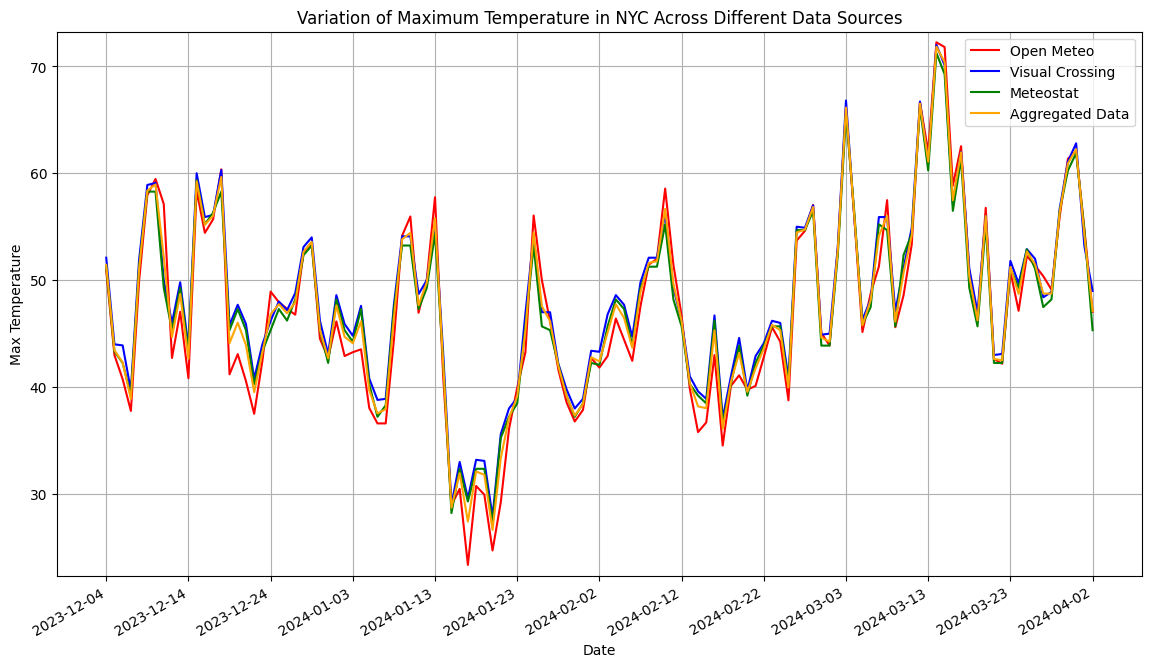

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df3['date'] = pd.to_datetime(df3['date'])
df['date'] = pd.to_datetime(df['date'])

all_max_temps = pd.concat([df1['max_temp'], df2['max_temp'], df3['max_temp'], df['max_temp']])
global_min_temp = all_max_temps.min()
global_max_temp = all_max_temps.max()

plt.figure(figsize=(14, 8))

plt.plot(df1['date'], df1['max_temp'], label='Open Meteo', color='red')
plt.plot(df2['date'], df2['max_temp'], label='Visual Crossing', color='blue')
plt.plot(df3['date'], df3['max_temp'], label='Meteostat', color='green')
plt.plot(df['date'], df['max_temp'], label='Aggregated Data', color='orange')

plt.ylim(global_min_temp-1, global_max_temp+1)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10)) 

plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.title('Variation of Maximum Temperature in NYC Across Different Data Sources')
plt.legend()
plt.grid(True)  
plt.show()


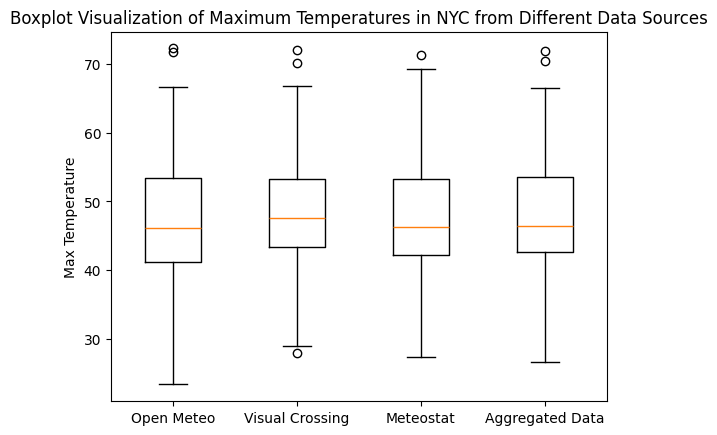

In [48]:
data_to_plot = [df1['max_temp'], df2['max_temp'], df3['max_temp'], df['max_temp']]
plt.boxplot(data_to_plot)
plt.xticks([1, 2, 3, 4], ['Open Meteo', 'Visual Crossing', 'Meteostat', 'Aggregated Data'])
plt.ylabel('Max Temperature')
plt.title('Boxplot Visualization of Maximum Temperatures in NYC from Different Data Sources')
plt.show()
